In [1]:
import pandas as pd
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

def set_seed(seed=42):
    """
    Set random seeds for reproducibility across Python, NumPy, and PyTorch.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # Force deterministic behavior for convolutional algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f">>> Global seed set to: {seed}")

set_seed(42)

>>> Global seed set to: 42


In [2]:
# --- Dataset Definition ---

class ShallowCustomNetDataset(Dataset):
    """
    Custom Dataset for loading driving images and corresponding steering angles.
    """
    def __init__(self, label_file, img_dir, transform=None):
        self.data = pd.read_csv(label_file, sep=' ', names=['filename', 'angle'], header=None)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        # Convert image to grayscale ('L' mode) as per project requirements
        image = Image.open(img_name).convert('L') 
        
        angle = torch.tensor([float(self.data.iloc[idx, 1])], dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, angle

In [3]:
# --- Image Transforms ---

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

eval_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
# --- Model Architecture ---

class ShallowCustomNet(nn.Module):
    """
    Enhanced Shallow Architecture:
    - Added Batch Normalization for training stability and regularization.
    - Optimized Fully Connected layers with dual dropout.
    """
    def __init__(self):
        super(ShallowCustomNet, self).__init__()
        
        # Conv Block 1
        self.conv1 = nn.Conv2d(1, 24, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(24)
        
        # Conv Block 2
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(36)
        
        # Conv Block 3
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(48)
        
        # Fully Connected Block
        # Input features: 48 channels * 5 * 5 spatial grid = 1200
        self.fc1 = nn.Linear(48 * 9 * 9, 100)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.5) 
        
        self.fc3 = nn.Linear(50, 1)
        

    def forward(self, x):
        # Convolutional path with Batch Norm and ELU
        x = F.elu(self.bn1(self.conv1(x)))
        x = F.elu(self.bn2(self.conv2(x)))
        x = F.elu(self.bn3(self.conv3(x)))
        
        x = x.view(x.size(0), -1) # Flatten
        
        # FC path with regularization
        x = F.elu(self.fc1(x))
        x = self.dropout1(x)
        x = F.elu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [5]:
# --- Training and Validation Functions ---

def train_and_plot(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, log_name="final_run"):
    history = {'epoch': [], 'train_rmse': [], 'val_rmse': [], 'lr': []}
    best_val_rmse = float('inf') 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view_as(outputs))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                v_loss = criterion(outputs, labels.float().view_as(outputs))
                val_loss += v_loss.item()
        
        # Calculate RMSE (Root Mean Squared Error)
        t_rmse = math.sqrt(train_loss / len(train_loader))
        v_rmse = math.sqrt(val_loss / len(val_loader))
      
        # Update Learning Rate Scheduler
        scheduler.step() 
        current_lr = optimizer.param_groups[0]['lr']

        history['epoch'].append(epoch + 1)
        history['train_rmse'].append(t_rmse)
        history['val_rmse'].append(v_rmse)
        history['lr'].append(current_lr)
        
        print(f"Epoch {epoch+1}: LR: {current_lr:.6f}, Train RMSE: {t_rmse:.4f}, Val RMSE: {v_rmse:.4f}")
        
        # Save the best model based on validation performance
        if v_rmse < best_val_rmse:
            best_val_rmse = v_rmse
            torch.save(model.state_dict(), 'best_pilotnet_model.pth')
            print(f">>> New best model saved with Val RMSE: {v_rmse:.4f}")

    # --- Save Logs and Plotting ---
    log_df = pd.DataFrame(history)
    log_filename = f"log_{log_name}_{datetime.now().strftime('%m%d_%H%M')}.csv"
    log_df.to_csv(log_filename, index=False)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), history['train_rmse'], label='Train RMSE', marker='o')
    plt.plot(range(1, epochs+1), history['val_rmse'], label='Val RMSE', marker='s')
    plt.axhline(y=best_val_rmse, color='r', linestyle='--', label=f'Best Val RMSE: {best_val_rmse:.4f}')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('ShallowCustomNet Training Performance')
    plt.legend()
    plt.grid(True)
    
    plt.savefig('RMSE.png')
    plt.show()

Epoch 1: LR: 0.000500, Train RMSE: 0.2238, Val RMSE: 0.2594
>>> New best model saved with Val RMSE: 0.2594
Epoch 2: LR: 0.000500, Train RMSE: 0.1518, Val RMSE: 0.2431
>>> New best model saved with Val RMSE: 0.2431
Epoch 3: LR: 0.000500, Train RMSE: 0.1293, Val RMSE: 0.2386
>>> New best model saved with Val RMSE: 0.2386
Epoch 4: LR: 0.000500, Train RMSE: 0.1170, Val RMSE: 0.2368
>>> New best model saved with Val RMSE: 0.2368
Epoch 5: LR: 0.000100, Train RMSE: 0.1109, Val RMSE: 0.2238
>>> New best model saved with Val RMSE: 0.2238
Epoch 6: LR: 0.000100, Train RMSE: 0.0951, Val RMSE: 0.2160
>>> New best model saved with Val RMSE: 0.2160
Epoch 7: LR: 0.000100, Train RMSE: 0.0908, Val RMSE: 0.2172
Epoch 8: LR: 0.000100, Train RMSE: 0.0891, Val RMSE: 0.2252
Epoch 9: LR: 0.000100, Train RMSE: 0.0863, Val RMSE: 0.2179
Epoch 10: LR: 0.000020, Train RMSE: 0.0861, Val RMSE: 0.2229
Epoch 11: LR: 0.000020, Train RMSE: 0.0819, Val RMSE: 0.2188
Epoch 12: LR: 0.000020, Train RMSE: 0.0808, Val RMSE: 0.

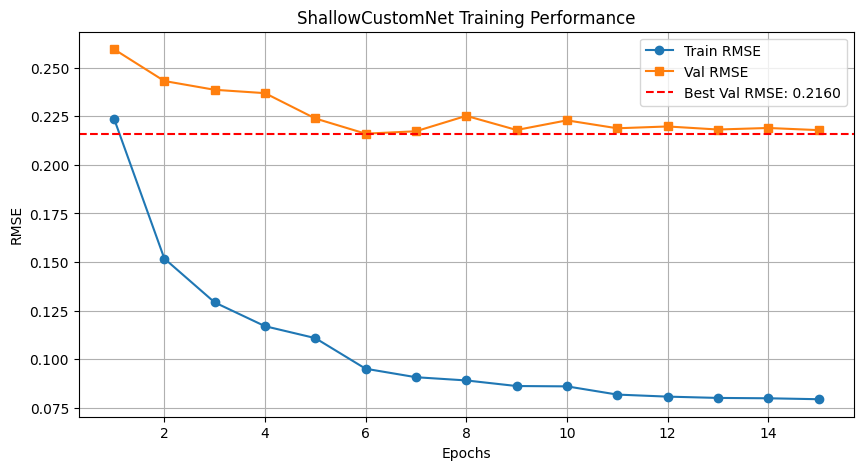

In [6]:
# --- Execution ---

    # 1. Data Loading
train_dataset = ShallowCustomNetDataset('train/labels.txt', 'train/images', transform=train_transform)
val_dataset = ShallowCustomNetDataset('val/labels.txt', 'val/images', transform=eval_transform)
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

    # 2. Model Initialization
model = ShallowCustomNet()
criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)
    
    # Using StepLR for predictable decay schedule
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)

    # 3. Start Training
train_and_plot(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    epochs=15,
    log_name="final_optimized_run"
    )

In [7]:
# --- Final Inference and Submission Generation ---

class ShallowCustomNetTestDataset(Dataset):
    """
    Dataset class specifically for the test set. 
    Loads images and their filenames for generating organized predictions.
    """
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        # Ensure files are sorted to maintain consistency
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        # Load as grayscale as required by model architecture
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, img_name

def generate_final_submission(model_path, test_dir, output_file='predictions.txt'):
    """
    Loads the best model weights and generates steering angle predictions for the test set.
    """
    # 1. Initialize Model and Load Weights
    model = ShallowCustomNet()
    if os.path.exists(model_path):
        # Load trained weights from the best checkpoint [cite: 2026-02-12]
        model.load_state_dict(torch.load(model_path))
        print(f">>> Successfully loaded best model from {model_path}")
    else:
        print(f"!!! Error: {model_path} not found. Ensure training finished successfully.")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # Set to evaluation mode (disables Dropout) [cite: 2026-02-12]

    # 2. Setup Test Dataloader
    test_dataset = ShallowCustomNetTestDataset(img_dir=test_dir, transform=eval_transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    results = []
    print(f">>> Running inference on {len(test_dataset)} test images...")

    # 3. Perform Inference
    with torch.no_grad(): # Disable gradient calculation for efficiency [cite: 2026-02-05]
        for inputs, filenames in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Extract scalar values from model outputs
            preds = outputs.cpu().squeeze().tolist()
            
            # Handle single-item batch case
            if isinstance(preds, float):
                preds = [preds]
                
            for fname, p in zip(filenames, preds):
                results.append(p)

    # 4. Save to predictions.txt (one angle per line as per PR2 requirements)
    with open(output_file, 'w') as f:
        for val in results:
            f.write(f"{val:.6f}\n")
    
    print(f">>> Submission file saved: {output_file}")

# --- Execute Inference ---

generate_final_submission(
    model_path='best_pilotnet_model.pth', 
    test_dir='test' # Adjust path based on your folder structure
)

>>> Successfully loaded best model from best_pilotnet_model.pth
>>> Running inference on 6811 test images...
>>> Submission file saved: predictions.txt
